**Load Libraries**

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import pickle as pkl

#Classification with KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Data Preprocessing

### Define Functions

In [2]:
def loadDataFrames(name, pathAcc, pathGyr, pathOri):
    df_Acc= pd.read_csv(pathAcc)
    df_Gyr= pd.read_csv(pathGyr)
    df_Ori= pd.read_csv(pathOri)
    print("Data Frames for " + name + " loaded.")
    return df_Acc, df_Gyr, df_Ori

def loadJsonData(name, pathJson):
    df = pd.read_json(pathJson)
    print("Data Frame for " + name + " loaded.")
    return df	   

#Concat Funktion
def concatDataFrames(name, df_Acc, df_Gyr, df_Ori):
  df_Gyr.drop(['time','seconds_elapsed'], axis=1, inplace=True)
  df_Ori.drop(['time','seconds_elapsed'], axis=1, inplace=True)
  df = pd.concat([df_Acc, df_Gyr, df_Ori], axis=1)
  print("Data Frames for " + name + " concatenated.")
  return df

#Function to plot Gyr Data
def plotDataGyr(data, title):
    plt.plot(data['time'], data['z'], color='red', marker='.')
    plt.plot(data['time'], data['y'], color='blue', marker='.')
    plt.plot(data['time'], data['x'], color='green', marker='.')
    plt.xlabel('time')
    plt.ylabel('x,y,z')
    plt.legend(['z', 'y', 'x'])
    plt.title(title)
    plt.show()

#Function to Plot Acc Data
def plotDataAcc(data, title):
    plt.plot(data['time'], data['z'], color='red', marker='.')
    plt.plot(data['time'], data['y'], color='blue', marker='.')
    plt.plot(data['time'], data['x'], color='green', marker='.')
    plt.xlabel('time')
    plt.ylabel('x,y,z')
    plt.legend(['z', 'y', 'x'])
    plt.title(title)
    plt.show()

#Function to Plot Ori Data
def plotDataOri(data, title):
    plt.plot(data['time'], data['qz'], color='red', marker='.')
    plt.plot(data['time'], data['qy'], color='blue', marker='.')
    plt.plot(data['time'], data['qx'], color='green', marker='.')
    plt.plot(data['time'], data['qw'], color='yellow', marker='.')
    #plt.plot(data['time'], data['roll'], color='black', marker='.')
    plt.xlabel('time')
    plt.ylabel('qz,qy,qx,qw,roll')
    plt.legend(['qz', 'qy', 'qx', 'qw', 'roll'])
    plt.title(title)
    plt.show()

#Clean Function Json Data
def cleanDataJson(df):
    df.drop(['version','device name','recording time','platform','appVersion', 'device id', 'sensors', 'sampleRateMs' ], axis=1, inplace=True)
    return df


### Load Data and give them a name

In [4]:
#load mixed data
df_mixed_Acc, df_mixed_Gyr, df_mixed_Ori =loadDataFrames('mixed','data/MixedData/Accelerometer.csv', 'data/MixedData/Gyroscope.csv', 'data/MixedData/Orientation.csv')

##############################################################################################################

#load data frames for walking
df_walk_Acc, df_walk_Gyr, df_walk_Ori =loadDataFrames('walking','data/NormalWalk/Accelerometer.csv', 'data/NormalWalk/Gyroscope.csv', 'data/NormalWalk/Orientation.csv')

#load data walk2
df_walk2_Acc, df_walk2_Gyr, df_walk2_Ori =loadDataFrames('walking 2','data/Walk2/Accelerometer.csv', 'data/Walk2/Gyroscope.csv', 'data/Walk2/Orientation.csv')

#load data walk3 Alex
df_walk3 = loadJsonData('walking 3', 'data\Alex_Rumstehen_-2023-05-02_15-30-58.json')

#load data walk4 Alex
df_walk4 = loadJsonData('walking 4', 'data\Alex_Rumstehen_2-2023-05-23_14-53-09.json')


##############################################################################################################

#load data frames for push ups
df_push_Acc, df_push_Gyr, df_push_Ori =loadDataFrames('push ups','data/PushUps/Accelerometer.csv', 'data/PushUps/Gyroscope.csv', 'data/PushUps/Orientation.csv')

#load data pushups2
df_push2_Acc, df_push2_Gyr, df_push2_Ori =loadDataFrames('push ups 2','data/PushUps2/Accelerometer.csv', 'data/PushUps2/Gyroscope.csv', 'data/PushUps2/Orientation.csv')

#load data pushups3 Alex
df_push3 = loadJsonData('push ups 3', 'data/Alex_Push_Up_2-2023-05-23_15-04-54.json')

#load data pushups4 Alex
df_push4 = loadJsonData('push ups 4', 'data\Alex_10_Liegestütz-2023-05-02_15-29-25.json')

##############################################################################################################

#load data frames for jumping jacks
df_JJ_Acc, df_JJ_Gyr, df_JJ_Ori =loadDataFrames('jumping jacks ','data/JJ_rightHand/Accelerometer.csv', 'data/JJ_rightHand/Gyroscope.csv', 'data/JJ_rightHand/Orientation.csv')

#load data JJ2
df_JJ2_Acc, df_JJ2_Gyr, df_JJ2_Ori =loadDataFrames('jumping jacks 2','data/JJ2/Accelerometer.csv', 'data/JJ2/Gyroscope.csv', 'data/JJ2/Orientation.csv')

#load data JJ3 Alex
df_JJ3 = loadJsonData('jumping jacks 3', 'data/Alex_10_Hampelmänner-2023-05-02_15-30-18.json')


Data Frames for mixed loaded.
Data Frames for walking loaded.
Data Frames for walking 2 loaded.
Data Frame for walking 3 loaded.
Data Frame for walking 4 loaded.
Data Frames for push ups loaded.
Data Frames for push ups 2 loaded.
Data Frame for push ups 3 loaded.
Data Frame for push ups 4 loaded.
Data Frames for jumping jacks loaded.
Data Frames for jumping jacks 2 loaded.
Data Frame for jumping jacks 3 loaded.


**Clean Up Json Data**

In [6]:
df_push3.head(-50)

,sensor,time,seconds_elapsed,z,y,x,version,device name,recording time,platform,...,device id,sensors,sampleRateMs,qz,qy,qx,qw,roll,pitch,yaw
0,Accelerometer,1.684854e+18,0.250194,0.307953,0.431771,0.084114,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Accelerometer,1.684854e+18,0.260115,0.395724,0.405924,0.168557,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Accelerometer,1.684854e+18,0.270073,0.541992,0.358083,0.195789,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Accelerometer,1.684854e+18,0.280069,0.425917,0.327375,0.108794,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Accelerometer,1.684854e+18,0.290102,-0.283370,0.668575,-0.726294,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16052,TotalAcceleration,1.684854e+18,26.728173,9.022549,7.021595,0.643442,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16053,TotalAcceleration,1.684854e+18,26.738194,8.716091,7.026383,0.715268,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16054,TotalAcceleration,1.684854e+18,26.748216,8.328231,6.992865,0.681749,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16055,TotalAcceleration,1.684854e+18,26.758238,7.858967,6.964134,0.648230,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_JJ3 = cleanDataJson(df_JJ3)

**Concat Dataframes**

In [12]:
#Concat DataFrames Walk
df_walk = concatDataFrames('walking', df_walk_Acc, df_walk_Gyr, df_walk_Ori)

#Concat DataFrames PushUps
df_push = concatDataFrames('push ups', df_push_Acc, df_push_Gyr, df_push_Ori)

#Concat DataFrames JumpingJacks
df_JJ = concatDataFrames('jumping jacks', df_JJ_Acc, df_JJ_Gyr, df_JJ_Ori)

#Concat DataFrames JumpingJacks2
df_JJ2 = concatDataFrames('jumping jacks 2', df_JJ2_Acc, df_JJ2_Gyr, df_JJ2_Ori)

#Concat DataFrames PushUps2
df_push2 = concatDataFrames('push ups 2', df_push2_Acc, df_push2_Gyr, df_push2_Ori)

#Concat DataFrames Walk2
df_walk2 = concatDataFrames('walking 2', df_walk2_Acc, df_walk2_Gyr, df_walk2_Ori)



#Concat Mixed DataFrames
df_mixed = concatDataFrames('mixed', df_mixed_Acc, df_mixed_Gyr, df_mixed_Ori)
df_mixed.head(10)

Data Frames for walking concatenated.
Data Frames for push ups concatenated.
Data Frames for jumping jacks concatenated.
Data Frames for jumping jacks 2 concatenated.
Data Frames for push ups 2 concatenated.
Data Frames for walking 2 concatenated.
Data Frames for mixed concatenated.


,time,seconds_elapsed,z,y,x,z,y,x,qz,qy,qx,qw,roll,pitch,yaw
0,1683885692643028200,0.177028,-2.262210,0.806162,-0.278753,1.603674,1.674687,1.103528,-0.811517,0.141371,0.161673,0.543430,0.429760,0.053760,1.949730
1,1683885692659893500,0.193894,-0.917953,0.798062,-0.267378,1.430036,3.169627,1.821600,-0.802009,0.128837,0.182105,0.554094,0.449906,0.004850,1.931321
2,1683885692676774100,0.210774,0.146413,2.362878,0.174195,0.722806,5.473352,2.473699,-0.790269,0.120772,0.199763,0.566555,0.469977,-0.035477,1.906112
3,1683885692693654300,0.227654,-0.701164,4.871797,1.817624,0.776257,3.543477,2.811965,-0.779568,0.117154,0.210182,0.578249,0.482549,-0.060452,1.880066
4,1683885692710510800,0.244511,-2.731052,5.407081,0.866909,1.809077,1.557248,2.462245,-0.774531,0.114960,0.200069,0.588947,0.462370,-0.057611,1.854921
5,1683885692727390000,0.261390,-2.588329,5.020437,0.968598,2.393064,1.090853,1.873524,-0.775383,0.116430,0.173566,0.595903,0.420332,-0.026304,1.836698
6,1683885692744263000,0.278263,-0.897709,4.194711,1.220492,2.288454,1.253648,1.089478,-0.778063,0.121911,0.147691,0.598284,0.385186,0.012987,1.828034
7,1683885692761133800,0.295134,0.574014,4.251270,0.604241,1.736385,-0.034208,0.004429,-0.778929,0.128120,0.134300,0.599014,0.371469,0.038707,1.823189
8,1683885692777996800,0.311997,-0.116035,1.576437,0.299314,0.749226,-1.894904,-1.542740,-0.779003,0.131234,0.131398,0.598888,0.370745,0.047095,1.821925
9,1683885692794875600,0.328876,-0.471364,1.944724,0.045150,-0.203265,-2.515390,-2.413681,-0.779734,0.131699,0.132513,0.597588,0.373048,0.047021,1.824888


# Plot Data

In [ ]:
df_push_Gyr.plot(x='time', y='z', kind='line')
df_push_Gyr.plot(x='time', y='y', kind='line')
df_push_Gyr.plot(x='time', y='x', kind='line')

<Axes: xlabel='time'>

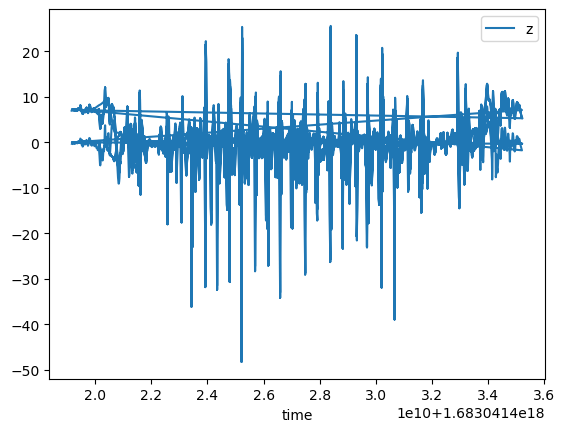

In [10]:
df_JJ3.plot(x='time', y='z', kind='line')

In [ ]:
#Plot Walk
plotDataGyr(df_walk_Gyr, 'Gyroscope Walk')

#Plot PushUps
plotDataGyr(df_push_Gyr, 'Gyroscope PushUps')

#Plot JumpingJacks
plotDataGyr(df_JJ_Gyr, 'Gyroscope JumpingJacks')

In [ ]:
#Plotting Accelerometer Data

#Plot Walk
plotDataAcc(df_walk_Acc, 'Accelerometer Walk')

#Plot PushUps
plotDataAcc(df_push_Acc, 'Accelerometer PushUps')

#Plot JumpingJacks
plotDataAcc(df_JJ_Acc, 'Accelerometer JumpingJacks')

In [ ]:
#Plot Walk
plotDataOri(df_walk_Ori, 'Orientation Walk')

#Plot PushUps
plotDataOri(df_push_Ori, 'Orientation PushUps')

#Plot JumpingJacks
plotDataOri(df_JJ_Ori, 'Orientation JumpingJacks')
    

# **KNN Classifikation**
1. Label Data
2. Concat Dataframes
3. Split Data
4. Train Model
5. Predict
6. Evaluate

### 1. Label Data

In [13]:
#Classification with KNN
#Function to label the data
def getData(data, label):
    data['label'] = label
    return data

#Label Data
#Label Data Walk
df_walk = getData(df_walk, 'walk')
#df_walk.head(10)

#Label Data PushUps
df_push = getData(df_push, 'pushups')
#df_push.head(10)

#Label Data JumpingJacks
df_JJ = getData(df_JJ, 'jumpingjacks')
#df_JJ.head(10)

#Label Data JumpingJacks2
df_JJ2 = getData(df_JJ2, 'jumpingjacks')

#Label Data PushUps2
df_push2 = getData(df_push2, 'pushups')

#Label Data Walk2
df_walk2 = getData(df_walk2, 'walk')

#Label Data Walk3
df_walk3 = getData(df_walk3, 'walk')

#Label Data Walk4
df_walk4 = getData(df_walk4, 'walk')

#Label Data Push3
df_push3 = getData(df_push3, 'pushups')

#Label Data Push4
df_push4 = getData(df_push4, 'pushups')

#Label Data JJ3
df_JJ3 = getData(df_JJ3, 'jumpingjacks')



### 2. Concat Dataframes

In [14]:
#Concat DataFrames
df = pd.concat([df_walk, df_push, df_JJ], axis=0)
df_test = pd.concat([df_JJ2, df_push2, df_walk2], axis=0)

#Short Df_test for predciton
df_test= df_test.head(1517)



#Fill NaN Values with propagation
df.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)



#kein random split sondern spezifizieren
#erste 70% train, letzte 30% test
#fünf trainings df und quasi im train nur die ersten 3 und die zwei anderen dann als test

In [15]:
#Concat both DataFrames to one big one and try with that one
df = pd.concat([df_walk, df_push, df_JJ, df_walk2, df_push2, df_JJ2], axis=0)

#Fill NaN Values with propagation
df.fillna(method='ffill', inplace=True)

In [16]:
print('Test: ', len(df_test))
print('Df: ', len(df))

df_test.drop(['label'], axis=1, inplace=True)

Test:  1517
Df:  11428


ToDo: Marvin
#gemischten Datensatz vlt mal testen, weiß noch nicht genau wie ich den einbauen soll

In [116]:
#df_test.head(10)
df_test.describe()

,time,seconds_elapsed,z,y,x,z,y,x,qz,qy,qx,qw,roll,pitch,yaw
count,1.517000e+03,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000
mean,1.683805e+18,6.598928,2.204194,-2.490929,9.363001,-0.196640,0.320282,0.204171,-0.355664,0.125975,-0.185568,0.498515,0.104165,0.195756,0.709972
std,8.296954e+14,3.720754,4.830265,15.504575,15.510745,4.095467,1.689686,1.855244,0.504884,0.470920,0.210246,0.232772,1.254140,0.725219,1.416115
min,1.682934e+18,0.169378,-14.339581,-77.281876,-32.071171,-10.522612,-6.238308,-6.855435,-0.846558,-0.912635,-0.667341,0.000313,-3.125728,-1.534696,-2.371765
25%,1.682934e+18,3.390385,-0.525890,-4.523671,0.418973,-0.908509,-0.493885,-0.427911,-0.788548,-0.014934,-0.292448,0.416943,-0.333178,-0.370145,-0.476067
50%,1.684595e+18,6.580984,0.970622,-0.247191,1.640636,-0.074831,0.137750,0.082161,-0.522688,0.286331,-0.225311,0.456533,-0.052166,0.146062,0.938619
75%,1.684595e+18,9.785685,3.882204,1.529319,19.191360,0.382707,0.903012,0.670119,-0.145508,0.469841,-0.020603,0.575918,0.634184,0.804053,2.103494
max,1.684595e+18,13.583174,27.060694,53.578690,63.185997,11.344684,7.002348,8.202699,0.868939,0.848110,0.466070,0.983424,3.102467,1.459254,2.287196


### 3. Split Data

In [17]:
#Split Data erste 70% train, letzte 30% test
X = df.drop(['label'], axis=1)
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size=0.3)

(7999, 15)
Index(['time', 'seconds_elapsed', 'z', 'y', 'x', 'z', 'y', 'x', 'qz', 'qy',
       'qx', 'qw', 'roll', 'pitch', 'yaw'],
      dtype='object')


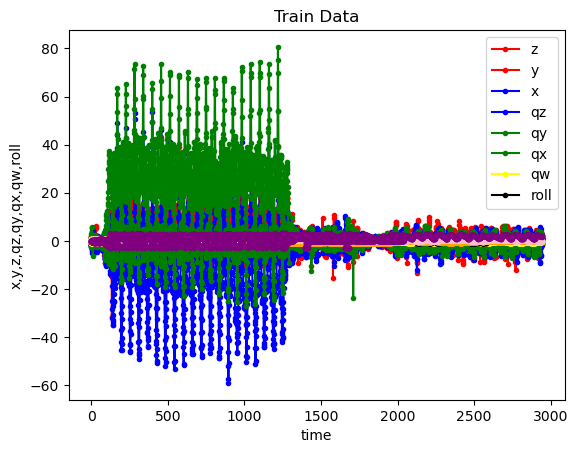

In [18]:
#Show Training Data
def showXTrainingData(data):
  print(data.shape)
  print(data.columns)
  plt.plot(data['z'], color='red', marker='.')#
  plt.plot(data['y'], color='blue', marker='.')#
  plt.plot(data['x'], color='green', marker='.')#
  plt.plot(data['qz'], color='yellow', marker='.')#
  plt.plot(data['qy'], color='black', marker='.')#
  plt.plot(data['qx'], color='orange', marker='.')#
  plt.plot(data['qw'], color='pink', marker='.')#
  plt.plot(data['roll'], color='purple', marker='.')#
  plt.xlabel('time')
  plt.ylabel('x,y,z,qz,qy,qx,qw,roll')
  plt.legend(['z', 'y', 'x', 'qz', 'qy', 'qx', 'qw', 'roll'])
  plt.title('Train Data')
  plt.show()

showXTrainingData(X_train)


### 4. Train Model

In [19]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)

#size passt noch nicht, da der ytest mehr data hat als der ypred
#shuffle data and then split

KNeighborsClassifier(n_neighbors=3, weights='distance')

### 5. Predict

In [20]:
y_pred = knn.predict(X_test)
print(len(y_test))

3429


### 6. Evaluate

In [21]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', cm)

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy * 100, '%')

#Recall
recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: ', recall * 100, '%')


Confusion Matrix: 
 [[   0    0  721]
 [   0    0 2105]
 [   0    0  603]]
Accuracy:  17.585301837270343 %
Recall:  17.585301837270343 %


In [ ]:
#Split Data Mixed
X_mixed = df_mixed.drop(['label'], axis=1)
y_mixed = df_mixed['label']
X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = train_test_split(X_mixed, y_mixed, test_size=0.3)

#KNN
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)
y_pred_mixed = knn.predict(X_test)

# Sonstiges

**Export Model into Pickle**

In [119]:
#pickle wird benutzt um das trainierte Modell zu speichern und dann in streamlit zu laden, dort können wir es dann auf den datensatz anwenden
pkl.dump(knn, open('knn.pkl', 'wb'))

Lösung von ChatGpt, leider nicht so einfach...

In [ ]:
# Daten laden
training_data = df.drop(['label'], axis=1)
training_labels = df['label']

# Sensordaten in eine zweidimensionale Form umwandeln
training_data = training_data.reshape(training_data.shape[0], -1)


# KNN-Modell erstellen und trainieren
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(training_data, training_labels)

# Sensordaten für eine neue Instanz
new_data = df_test
new_data = new_data.reshape(1, -1)

# Vorhersage für die neue Instanz
prediction = knn.predict([new_data])

# Wahrscheinlichkeiten der Vorhersagen
probabilities = knn.predict_proba([new_data])

# Index der vorhergesagten Klasse
predicted_class_index = prediction[0]

# Wahrscheinlichkeit der vorhergesagten Klasse
predicted_class_probability = probabilities[0][predicted_class_index]

# Klassenbezeichnungen
class_names = ['Jumping Jacks', 'Pushups', 'Laufen']

# Ergebnis ausgeben
result = f"Mit {predicted_class_probability*100:.2f}% Sicherheit hat die Person {class_names[predicted_class_index]} gemacht."
print(result)
